In [2]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
"""
Output must be--> device(type='cuda')
"""

cuda


"\nOutput must be--> device(type='cuda')\n"

In [3]:

# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoDetectionDataset(Dataset):
    # Init function: loads annotation file and prepares list of image IDs
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")

        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)

        # Package everything into a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms if any were passed
        if self.transforms:
            image = self.transforms(image)

        return image, target

In [4]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Returns a simple transform that converts a PIL image to a PyTorch tensor
def get_transform():
    return ToTensor()

# Load training dataset with transform applied
train_dataset = CocoDetectionDataset(
    # Change this to your path
    image_dir="train", 
    annotation_path="train/_annotations.coco.json",
    transforms=get_transform()
)

# Load validation dataset with same transform
val_dataset = CocoDetectionDataset(
    image_dir="valid",
    annotation_path="valid/_annotations.coco.json",
    transforms=get_transform()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


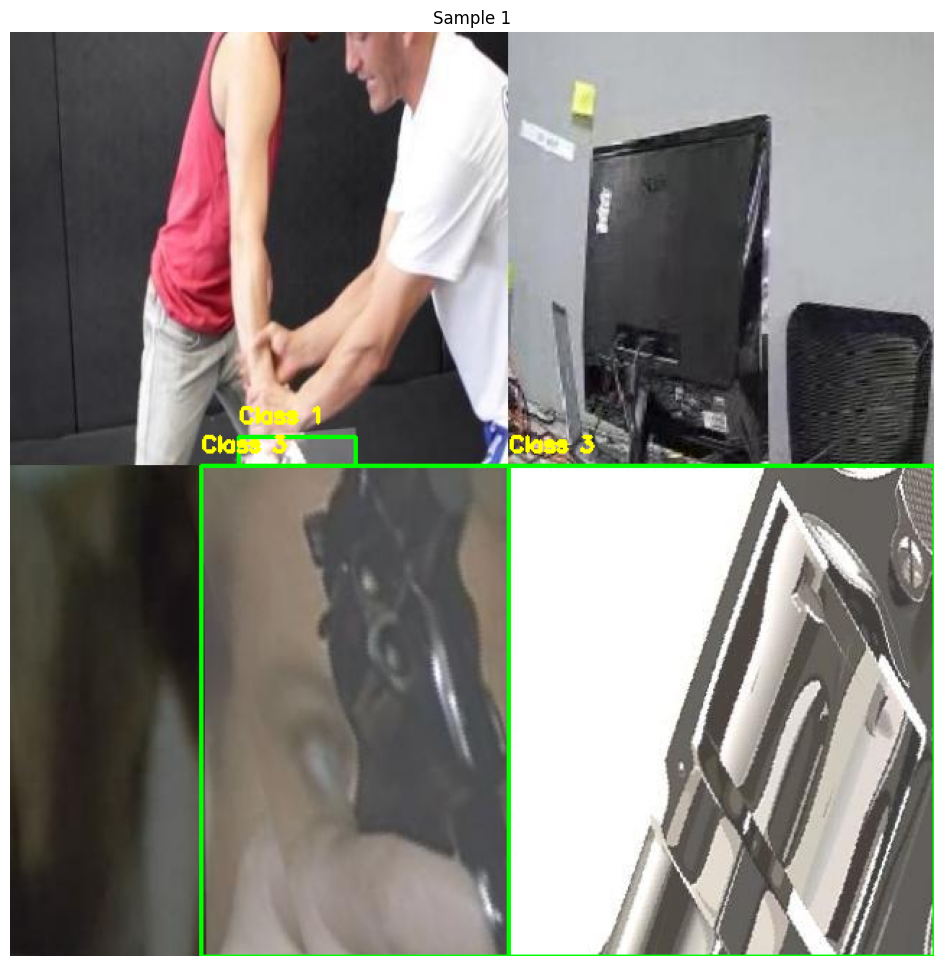

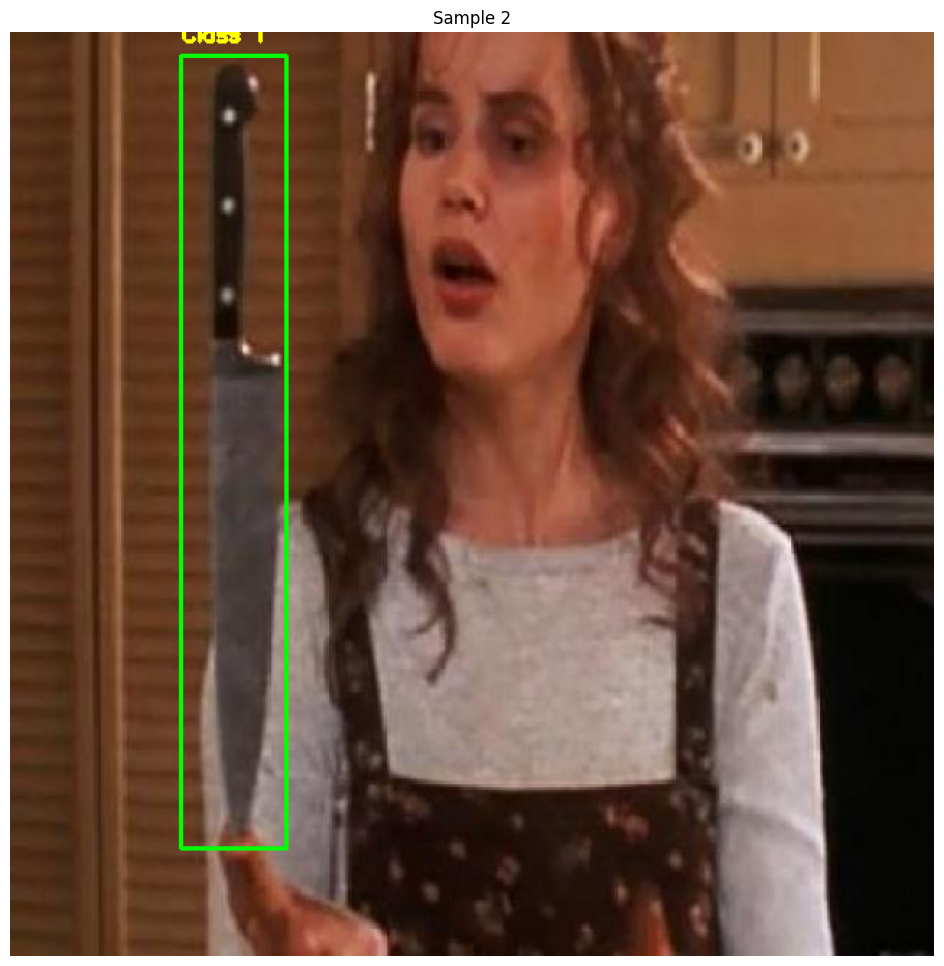

In [14]:
# Get one batch from the DataLoader
images, targets = next(iter(train_loader))

# Convert PIL Image and draw annotations
for i in range(len(images)):
    image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    image = (image * 255).astype(np.uint8)  # Rescale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    boxes = targets[i]['boxes']
    labels = targets[i]['labels']

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Class {label.item()}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Show image with boxes using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()

In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of classes in the dataset (including background)
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background class

# Get the number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features

"""  
Replace the classifier head with a new one for the custom dataset's classes
Number of classes must be equal to your label number
"""
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the specified device (GPU or CPU)
model.to(device)

c:\Users\IMG_PRO\anaconda3\envs\dip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\IMG_PRO\anaconda3\envs\dip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\IMG_PRO/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 62.1MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [15]:
from engine import train_one_epoch, evaluate


# Set the number of epochs for training
num_epochs = 10

# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")


Epoch 1/10


c:\Users\IMG_PRO\Desktop\HarmfulObject\RCNN\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [    0/12102]  eta: 5:29:24  lr: 0.000010  loss: 2.0903 (2.0903)  loss_classifier: 1.8534 (1.8534)  loss_box_reg: 0.1671 (0.1671)  loss_objectness: 0.0576 (0.0576)  loss_rpn_box_reg: 0.0121 (0.0121)  time: 1.6332  data: 0.0657  max mem: 1442
Epoch: [0]  [   25/12102]  eta: 0:44:03  lr: 0.000135  loss: 1.0064 (1.4074)  loss_classifier: 0.8851 (1.1195)  loss_box_reg: 0.1122 (0.1722)  loss_objectness: 0.0316 (0.0964)  loss_rpn_box_reg: 0.0114 (0.0193)  time: 0.1618  data: 0.0191  max mem: 1597
Epoch: [0]  [   50/12102]  eta: 0:38:59  lr: 0.000260  loss: 0.3977 (0.9731)  loss_classifier: 0.2203 (0.6996)  loss_box_reg: 0.1489 (0.1701)  loss_objectness: 0.0264 (0.0861)  loss_rpn_box_reg: 0.0113 (0.0173)  time: 0.1692  data: 0.0187  max mem: 1597
Epoch: [0]  [   75/12102]  eta: 0:36:58  lr: 0.000385  loss: 0.4757 (0.8278)  loss_classifier: 0.2264 (0.5534)  loss_box_reg: 0.1718 (0.1804)  loss_objectness: 0.0309 (0.0783)  loss_rpn_box_reg: 0.0089 (0.0157)  time: 0.1633  data: 0.0219

In [16]:
from torchvision import models, transforms

In [45]:
# Print all category names in your training dataset
cat_ids = train_dataset.coco.getCatIds()
cat_names = [train_dataset.coco.loadCats(i)[0]['name'] for i in cat_ids]
print("Category names:", cat_names)

Category names: ['gun-knife', '-', 'gun', 'gun-knife-thesis - v11 Yolov5 augmented', 'knife']


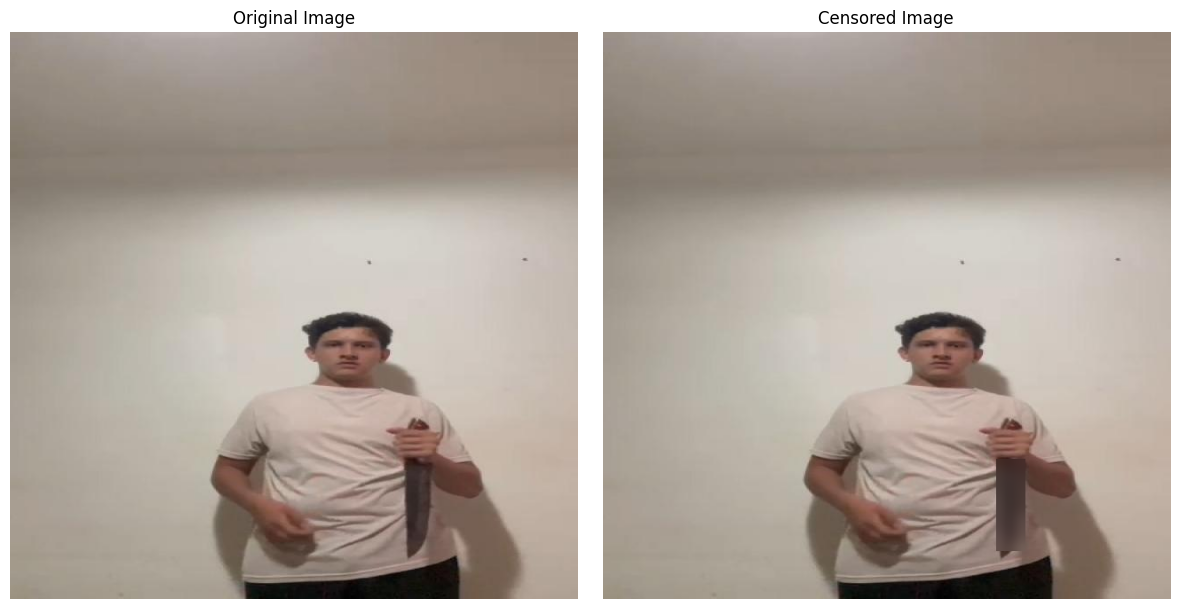

In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def censor_harmful_objects(model, image_path, label_list, threshold=0.5):
    # Load and preprocess image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    image_tensor = transforms.ToTensor()(image_pil).unsqueeze(0)

    # Inference
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    # Blur detected objects
    censored_img = image_rgb.copy()
    for i in range(len(boxes)):
        if scores[i] > threshold:
            box = boxes[i].cpu().numpy().astype(int)
            x1, y1, x2, y2 = box
            roi = censored_img[y1:y2, x1:x2]
            if roi.size > 0:
                blurred_roi = cv2.GaussianBlur(roi, (51, 51), 0)
                censored_img[y1:y2, x1:x2] = blurred_roi

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(censored_img)
    plt.title('Censored Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return censored_img

# Usage example
image_path = r"test\WhatsApp-Video-2023-11-22-at-19_47_53_mp4-803_jpg.rf.1259650c115c7fdb42d58248b99a9a36.jpg"
censored_result = censor_harmful_objects(model, image_path, label_list, threshold=0.5)